# Playground for testing neural network acquisition optimization

In [ ]:
%matplotlib inline
from functools import partial
import os
import sys
import GPyOpt
import numpy as np
from shinyutils.matwrap import MatWrap as mw
from tensorboardX import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from infopt.ihvp import LowRankIHVP
from infopt.nnacq import NNAcq
from infopt.nnmodel import NNModel

## Network used to model data

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return self.fc3(x)

## Objective function

In [ ]:
f_true = GPyOpt.objective_examples.experiments1d.forrester(sd=0)
f_noisy = GPyOpt.objective_examples.experiments1d.forrester(sd=1)
bounds = [{"name": "var_1", "type": "continuous", "domain": (0, 1)}]
f_min = f_true.fmin

## Optimization setup

In [ ]:
tb_writer = SummaryWriter("logs/nnacq_play")

net = Net()
ihvp = LowRankIHVP(
    net.parameters(),
    rank=5,
    optim_cls=optim.Adam,
    optim_kwargs={"lr": 0.05},
    batch_size=np.inf,
    iters_per_point=10,
    tb_writer=tb_writer,
)
net_optim = optim.Adam(net.parameters(), lr=0.05)
nn_model = NNModel(
    net,
    ihvp,
    net_optim,
    update_batch_size=np.inf,
    update_iters_per_point=10,
    tb_writer=tb_writer,
)

objective = GPyOpt.core.task.SingleObjective(f_noisy.f)
space = GPyOpt.Design_space(space=bounds)
initial_design = GPyOpt.experiment_design.initial_design("random", space, 5)
acq = NNAcq(
    nn_model,
    space,
    exploration_weight=2,
    tb_writer=tb_writer,
    optim_cls=optim.Adam,
    optim_kwargs={"lr": 0.01},
    optim_iters=100,
)
# acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
# acq = GPyOpt.acquisitions.AcquisitionLCB(nn_model, space, acq_optimizer,
#                                          exploration_weight=2)
feval = GPyOpt.core.evaluators.Sequential(acq)
nn_bo = GPyOpt.methods.ModularBayesianOptimization(
    nn_model, space, objective, acq, feval, initial_design, normalize_Y=True
)

nn_bo.Y, _ = nn_bo.objective.evaluate(nn_bo.X)
nn_bo.num_acquisitions = 0
nn_bo.model_parameters_iterations = None
nn_bo.context = None

X_te = np.linspace(0, 1, 100)[:, np.newaxis]
Y_te = f_true.f(X_te)

## Single optimization step

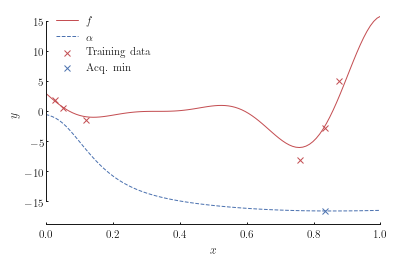

In [ ]:
nn_bo._update_model(nn_bo.normalization_type)
nn_bo.suggested_sample = nn_bo._compute_next_evaluations()
nn_bo.X = np.vstack((nn_bo.X, nn_bo.suggested_sample))
nn_bo.evaluate_objective()

M_te, S_te = nn_model.predict(X_te)
mu, sig = float(nn_bo.Y.mean()), float(nn_bo.Y.std())
if sig > 0:
    M_te = sig * M_te
    S_te = sig * S_te
M_te = M_te + mu
A_te = M_te - acq.exploration_weight * S_te

acq_xmin = nn_bo.suggested_sample
acq_fmin = A_te[np.argmin(np.abs(X_te - acq_xmin))]

mw.configure(context="notebook", backend="macosx")
fig = mw.plt().figure()
ax = fig.add_subplot(111)
ax.plot(X_te[:, 0], Y_te[:, 0], label="$f$", color="r")
ax.scatter(nn_bo.X[:, 0], nn_bo.Y[:, 0], color="r", marker="x", label="Training data")
ax.plot(X_te[:, 0], A_te[:, 0], color="b", linestyle="--", label="$\\alpha$")
ax.scatter(acq_xmin, acq_fmin, color="b", marker="x", label="Acq. min")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(0, 1)
ax.legend()
mw.sns().despine(fig=fig, ax=ax, trim=True)

In [ ]:
acq.x

tensor([[0.8356]], requires_grad=True)